In [27]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F  # To use the functional version of relu
from torchsummary import summary

import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

#### Линейная модель

In [13]:
class FCNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=28*28, out_features=64)
        self.fc2 = nn.Linear(64, 10)
        # self.sigmoid = nn.Sigmoid

    def forward(self, x):         # x.size = (32, 1, 28, 28)
        x = x.view(x.size(0), -1) # x.size = (32, 1 * 28 *28)
        x = self.fc1(x)           # x.size = (32, 64)
        x = F.relu(x)             # x.size = (32, 64)   #
        x = self.fc2(x)           # x.size = (32, 10)
        x = F.relu(x)             # x.size = (32, 10)
        x = F.log_softmax(x,  dim=1)   # x.size = (32, 10)
        return x

#### Сверточная модель

In [33]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, (3, 3), padding=1)
        self.conv2 = nn.Conv2d(64, 64, (3, 3), padding=1)
        self.max_pool = nn.MaxPool2d(2, stride=2)
        self.fc = nn.Linear(in_features=64*7*7, out_features=10)

    def forward(self, x):           # x.shape = 32 x 1 x 28 x 28
        x = F.relu(self.conv1(x))   # x.shape = 32 x 64 x 28 x 28
        x = self.max_pool(x)        # x.shape = 32 x 64 x 14 x 14
        x = F.relu(self.conv2(x))   # x.shape = 32 x 64 x 14 x 14
        x = self.max_pool(x)        # x.shape = 32 x 64 x 7 x 7

        x = x.view(x.size(0), -1)   # x.shape = 32 x 64*7*7

        x = self.fc(x)              # x.shape = 32 x 10
        x = F.log_softmax(x, dim=1) # x.shape = 32 x 10
        return x

#### Загрузка данных

In [16]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data',
                                          train=False,
                                          transform=transforms.ToTensor())

# Data loader
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True)

test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              shuffle=False)

In [7]:
item, label = next(iter(train_dataloader))

Text(0.5, 1.0, 'tensor(6)')

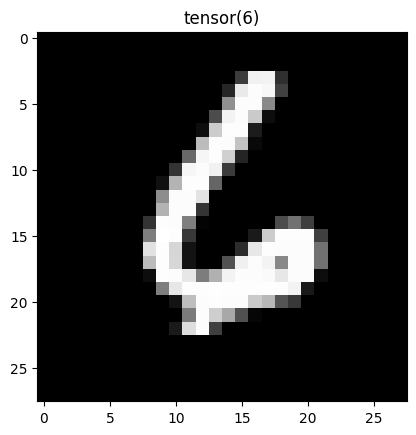

In [12]:
plt.imshow(item[30][0], cmap='gray')
plt.title(label[30])

In [19]:
len(train_dataset)

60000

### Обучение моделей

In [17]:
num_epochs = 2
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
model = ConvNet()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

In [35]:
model.to(device)

ConvNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=3136, out_features=10, bias=True)
)

In [36]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
         MaxPool2d-2           [-1, 64, 14, 14]               0
            Conv2d-3           [-1, 64, 14, 14]          36,928
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Linear-5                   [-1, 10]          31,370
Total params: 68,938
Trainable params: 68,938
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.60
Params size (MB): 0.26
Estimated Total Size (MB): 0.86
----------------------------------------------------------------


In [38]:
# Train the model
loss_list = []
total_step = len(train_dataloader)

for epoch in range(1, num_epochs + 1):
    for i, (images, labels) in enumerate(train_dataloader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        labels = F.one_hot(labels, num_classes=10).float()  # labels to tensor

        # Forward pass
        outputs = model(images)
        loss = loss_function(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_list.append(loss.detach().cpu().numpy())
        if (i) % 100 == 0:
            print (f'Epoch [{epoch}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')

print (f'Epoch [{epoch}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')

Epoch [1/2], Step [1/1875], Loss: 2.2974
Epoch [1/2], Step [101/1875], Loss: 2.2698
Epoch [1/2], Step [201/1875], Loss: 2.2521
Epoch [1/2], Step [301/1875], Loss: 2.1955
Epoch [1/2], Step [401/1875], Loss: 2.1366
Epoch [1/2], Step [501/1875], Loss: 2.0892
Epoch [1/2], Step [601/1875], Loss: 2.0404
Epoch [1/2], Step [701/1875], Loss: 1.9392
Epoch [1/2], Step [801/1875], Loss: 1.8522
Epoch [1/2], Step [901/1875], Loss: 1.5772
Epoch [1/2], Step [1001/1875], Loss: 1.4355
Epoch [1/2], Step [1101/1875], Loss: 1.2966
Epoch [1/2], Step [1201/1875], Loss: 1.4222
Epoch [1/2], Step [1301/1875], Loss: 0.9493
Epoch [1/2], Step [1401/1875], Loss: 1.0043
Epoch [1/2], Step [1501/1875], Loss: 0.7741
Epoch [1/2], Step [1601/1875], Loss: 0.9331
Epoch [1/2], Step [1701/1875], Loss: 0.6952
Epoch [1/2], Step [1801/1875], Loss: 0.7800
Epoch [2/2], Step [1/1875], Loss: 0.6472
Epoch [2/2], Step [101/1875], Loss: 0.6023
Epoch [2/2], Step [201/1875], Loss: 0.4171
Epoch [2/2], Step [301/1875], Loss: 0.5753
Epoch 

### Валидация моделей

In [39]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the MNIST test images: {} %'.format(100 * correct / total))


Accuracy of the network on the MNIST test images: 88.96 %


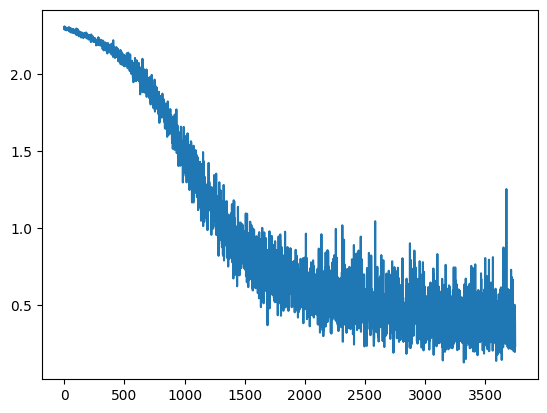

In [40]:
plt.plot(loss_list)

In [ ]:
torch.save(model.state_dict(), 'model.ckpt')